# 実験計画法 (Design of Experiments, DoE)


In [0]:
import numpy as np 
import pandas as pd

  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-cp36-none-any.whl size=25519 sha256=59ddb72ba21f0659cee848d43b576914d01c0b4afb40d9695ea2f0e57b472f1b
  Stored in directory: /root/.cache/pip/wheels/60/88/1d/b334ee00dd83e82d111ec56c3be91573d335c93870698037f1
Successfully built pyDOE2


## pyDOEによるデモ 

pyDOEというパッケージにいくつか実験計画法の手法が登録されている。 <br>
所望の手法があれば利用すると良い。<br>
以下はfull factorial手法の例（2因子3水準）。

In [0]:
!pip install pyDOE2
import pyDOE2 as pyDOE
pyDOE.fullfact([2, 3])# 2因子 3水準

array([[0., 0.],
       [1., 0.],
       [0., 1.],
       [1., 1.],
       [0., 2.],
       [1., 2.]])

## 直交計画表の関数を作る 

直交計画表を作る関数を定義する。<br>
因子数を入力したら直交表が出力される。<br> 

In [0]:
def orthogonal_table(n_factors=7):
  """ Orthogonal table """
  n_pow = np.ceil(np.log2(n_factors))
  n_bases = 2**int(n_pow)
  bases = np.array([list(map(int, '{:09b}'.format(val)))for val in range(n_bases)])
  kernels = [bases[:,np.where(row>0)[0]] 
            for row in bases if len(np.where(row>0)[0])>0]
  indexes = [np.where(row>0)[0].tolist()
           for row in bases if len(np.where(row>0)[0])>0]
  indexes = sorted(indexes,key=lambda x:len(x))
  D = np.zeros((bases.shape[0], len(indexes)),dtype=np.bool)
  for enum, ix in enumerate(indexes):
    for i_ in ix:
      if ix[0]==i_:
        D[:, enum] = bases[:, i_]
      else:
        D[:, enum] = D[:, enum] ^ bases[:, i_]
  return np.array([[2 if v else 1 for v in row] for row in D])

In [0]:
for i in [7, 14, 21]:
  X = orthogonal_table(i)
  print(len(X), len(X[0]))

8 7
16 15
32 31


In [0]:
D = orthogonal_table(7)
columns=[''] * D.shape[1]
columns[0]='A'
columns[2]='B'
columns[4]='C'
columns[6]='D'
#割付
df=pd.DataFrame(D,columns=columns)
df['measure'] = [40,46,28,18,32,26,32,58]
df

,A,,B,,C,,D,measure
0,1,1,1,1,1,1,1,40
1,2,1,1,2,2,1,2,46
2,1,2,1,2,1,2,2,28
3,2,2,1,1,2,2,1,18
4,1,1,2,1,2,2,2,32
5,2,1,2,2,1,2,1,26
6,1,2,2,2,2,1,1,32
7,2,2,2,1,1,1,2,58


In [0]:

df_alloc = df[['A','B','C','D','measure']]

In [0]:
df_alloc

,A,B,C,D,measure
0,1,1,1,1,40
1,2,1,2,2,46
2,1,1,1,2,28
3,2,1,2,1,18
4,1,2,2,2,32
5,2,2,1,1,26
6,1,2,2,1,32
7,2,2,1,2,58


In [0]:
print(df_alloc['measure'].sum()/8)
m = df_alloc['measure'].mean()

35.0


## ANOVA

分散分析(ANalysis Of VAriance, ANOVA)を実施する。<br>
直交計画法などは、それぞれの因子が直交<br>
（無相関）していると仮定しているので、<br>
応答（目的変数のこと）の分散が<br>
因子ごとの分散の和で表せる。

In [0]:
INPUT=df_alloc.columns[df_alloc.columns!='measure']

In [0]:
effects_factors = [np.array([df_alloc.loc[df_alloc[factor]==level]['measure'].mean() - m for level in [1, 2]])
      for factor in INPUT]

In [0]:
print(*effects_factors)

[-2.  2.] [-2.  2.] [ 3. -3.] [-6.  6.]


In [0]:
ss_total = np.sum(df_alloc['measure']**2)

In [0]:
CT = m ** 2 * df_alloc.shape[0]

In [0]:
squaresum = np.array([np.sum(effect**2.)*(df_alloc.shape[0]/2.)for effect in effects_factors])
squaresum

array([ 32.,  32.,  72., 288.])

In [0]:
diff_factors = np.array([np.array([effects_factors[ix_factor][val - 1] for val in df_alloc[factor]])
 for ix_factor, factor in enumerate(INPUT)])

In [0]:
e = df_alloc['measure'] - diff_factors.T.sum(axis=1)
e**2.

0    2209.0
1    1849.0
2     529.0
3     729.0
4     841.0
5     625.0
6    1681.0
7    2025.0
Name: measure, dtype: float64

In [0]:
if squaresum.sum()+np.sum(e**2.)==ss_total:
  print('SS_total', ss_total, ':', 'SS_factors', squaresum.sum()+np.sum(e**2.))
  print('It is true that: SS = S_a + S_b + S_c + S_d + S_e')

SS_total 10912 : SS_factors 10912.0
It is true that: SS = S_a + S_b + S_c + S_d + S_e


In [0]:
CT/1, squaresum/1
np.sum(e**2.) / (df_alloc.shape[0]-1-len(INPUT))

3496.0

In [0]:
v_factors = squaresum/1
v_error = np.sum(e**2.) / (df_alloc.shape[0]-1-len(INPUT))

In [0]:
v_factors / v_error

array([0.00915332, 0.00915332, 0.02059497, 0.08237986])

## 結論

F値について、いかが成り立つ。

$$
F_3^1=\left\{ \begin{array}{l} 10.13 \\ 34.12 \end{array} \right.
$$

これと上記の結果から、<br>
「**今回の割付では因子A, B, C, Dの分散は<br>
誤差分散との有意差があるとは言えない**」<br>
と言える。

もう少しわかりやすい言い換えると、<br>
今回のような実験結果が得られたときに、<br> 
因子A~Dは誤差項と同じ程度の分散しか持っていない<br>
ということになる。応答（目的変数）を<br>
重回帰モデルで予測する際に有効な変数は<br>
今回は取得できていないということになる。

実際の実験に利用する際には、実験結果である物性値に<br>
影響を与えている因子が特定できなかったことを意味する。

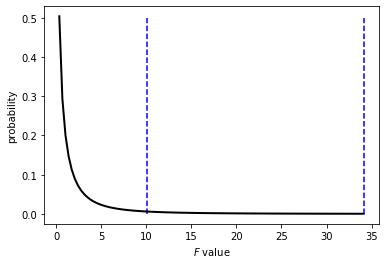

In [0]:
import numpy as np 
from scipy.stats import f
import matplotlib.pyplot as plt
dfn = 1 # degree of freedom, nominator
dfd = 3 # degree of freedom, denominator
rv = f(dfn, dfd)
x = np.linspace(f.ppf(0., dfn, dfd),
                f.ppf(0.99, dfn, dfd), 100)
fig , ax = plt.subplots(1,1)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
plt.vlines(10.13,ymin=0,ymax=.5, colors='blue', linestyles='dashed')
plt.vlines(34.12,ymin=0,ymax=.5, colors='blue', linestyles='dashed')
plt.xlabel('$F$ value');
plt.ylabel('probability');